# Optimizing through simulation with DeltaFlow

DeltaFlow supports **differentiable simulation**: you can compute the gradient of simulation outputs with respect to simulation inputs, thanks to Jax's autograd. 

This lets you do all kinds of wizardry. Here, we're going to demonstrate **inverse statistical mechanics**: finding the initial velocity field that turns a checkerboard into a Δ.

In [1]:
# Path hack to import base package
import sys
sys.path.append("..")

import deltaflow

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from PIL import Image

# Format matplotlib animations.
rc("animation", html="html5", bitrate=-1)

## Setting up the target and initial conditions

We'll load an image as the target, and start with a black-and-white checkerboard dye.

In [2]:
# Defines the sizes of all images and grids
x_resolution = 600
y_resolution = 600

(600, 600, 3)


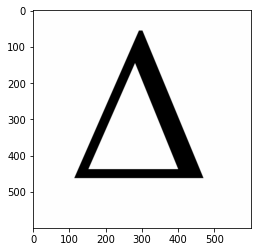

In [3]:
# Load and visualize the target image
target_image = Image.open("../resources/delta.png")
target = jnp.asarray(target_image.resize((x_resolution, y_resolution))) / 255

plt.imshow(target)
print(target.shape)

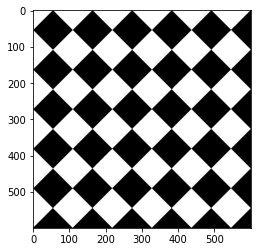

In [4]:
# Initialize the colors to a checkerboard pattern
color = np.zeros((y_resolution, x_resolution, 3))
y_wave = np.sin(np.linspace(-5.5 * np.pi, 5.5 * np.pi, num=y_resolution))
x_wave = np.sin(np.linspace(-5.5 * np.pi, 5.5 * np.pi, num=x_resolution))
color[:, :, :] = ((x_wave[np.newaxis, :] + y_wave[:, np.newaxis] + 2) / 4 > 0.5)[
    :, :, np.newaxis
]
color = jax.device_put(color)

plt.imshow(color)

## Defining a simulation-based loss function

Our goal is to find initial velocities that evolve this checkerboard into the target image. 

To do that, we'll define a loss function which:
 - Runs a fluid simulation for 100 timesteps, starting with checkerboard colors and the learned velocities.
 - Compares the last frame of the simulation to the target.
 - Returns the mean squared error between simulation and target, averaged over all of the pixels.

In [5]:
timesteps = 100

simulation_config = deltaflow.SimulationConfig(
    delta_t=0.1,
    density_coeff=1.0,
    diffusion_coeff=0.0,
)


def loss_function(velocity):
    final_color, final_velocity = deltaflow.simulate(
        timesteps,
        color,
        velocity,
        config=simulation_config,
        return_frames=False,
        disable_progress_bar=True,
    )

    return ((final_color - target) ** 2).mean()


initial_velocity = jnp.zeros((x_resolution, y_resolution, 2))
print("Loss:", loss_function(initial_velocity))

Loss: 0.5124614


## Gradients through the simulation

Becuase the whole loss computation (including the simulation!) is differentiable, we can compute the gradient of loss with respect to initial velocities.

The Jax function `value_and_grad` transforms a function `f` into another function `g` that computes `f` and its gradient together. Using this on the loss function, we can compute how small changes to the initial velocities affect the final error.

In [6]:
loss_and_grad = jax.value_and_grad(loss_function)

loss, grad = loss_and_grad(initial_velocity)
print("Loss:", loss)
print("Velocity gradient shape:", grad.shape)

Loss: 0.5124614
Velocity gradient shape: (600, 600, 2)


## Optimizing the initial velocities

Once we have the gradient, the optimization loop is just simple gradient descent:
 - Calculate the loss and its gradient.
 - Update the velocity by a small step in the direction of the negative gradient.
 - Rinse and repeat.

In [7]:
training_steps = 200

# High learning rate because the loss gradient is very small.
learning_rate = 1e6

velocity = jnp.array(initial_velocity)

for step in range(training_steps):
    loss, velocity_grad = loss_and_grad(velocity)
    velocity = velocity - learning_rate * velocity_grad

    if step % 10 == 0:
        print("Step " + str(step) + " loss: " + str(loss))

Step 0 loss: 0.5124614
Step 10 loss: 0.3300945
Step 20 loss: 0.2767254
Step 30 loss: 0.24116212
Step 40 loss: 0.21753275
Step 50 loss: 0.1980595
Step 60 loss: 0.18443729
Step 70 loss: 0.17145997
Step 80 loss: 0.16226679
Step 90 loss: 0.15297212
Step 100 loss: 0.14473255
Step 110 loss: 0.14062072
Step 120 loss: 0.133461
Step 130 loss: 0.12832204
Step 140 loss: 0.123676285
Step 150 loss: 0.11870609
Step 160 loss: 0.116074085
Step 170 loss: 0.11334982
Step 180 loss: 0.109079964
Step 190 loss: 0.10662183


## Visualizing the results

Finally, we'll run the simulation again and collect the frames, and write them into an animation.

In [8]:
color_frames, velocity_frames = deltaflow.simulate(
    timesteps,
    color,
    velocity,
    config=simulation_config,
)

deltaflow.utils.animate_frames(color_frames, interval=60)

Simulating: 100%|██████████| 100/100 [00:00<00:00, 349.01frame/s]
